In [2]:
#IMPORT SEMUA LIBRARY DISINI

In [3]:
#IMPORT LIBRARY PANDAS
import pandas as pd
#IMPORT LIBRARY POSTGRESQL
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
#IMPORT LIBRARY CHART
from matplotlib import pyplot as plt
from matplotlib import style
#IMPORT LIBRARY PDF
from fpdf import FPDF
#IMPORT LIBRARY BASEPATH
import io
#IMPORT LIBRARY BASE64 IMG
import base64
#IMPORT LIBRARY NUMPY
import numpy as np
#IMPORT LIBRARY EXCEL
import xlsxwriter 
#IMPORT LIBRARY SIMILARITAS
import n0similarities as n0

In [4]:
#FUNGSI UNTUK MENGUPLOAD DATA DARI CSV KE POSTGRESQL

In [5]:
def uploadToPSQL(host, username, password, database, port, table, judul, filePath, name, subjudul, dataheader, databody):
    #TEST KONEKSI KE DATABASE
    try:
        for t in range(0, len(table)):
            #DATA DIJADIKAN LIST
            rawstr = [tuple(x) for x in zip(dataheader, databody[t])]
            #KONEKSI KE DATABASE
            connection = psycopg2.connect(user=username,password=password,host=host,port=port,database=database)
            cursor = connection.cursor()
            connection.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT);
            #CEK TABLE
            cursor.execute("SELECT * FROM information_schema.tables where table_name=%s", (table[t],))
            exist = bool(cursor.rowcount)
            #KALAU ADA DIHAPUS DULU, TERUS DICREATE ULANG
            if exist == True:    
                cursor.execute("DROP TABLE "+ table[t] + " CASCADE")
                cursor.execute("CREATE TABLE "+table[t]+" (index SERIAL, tanggal date, total varchar);")
            #KALAU GA ADA CREATE DATABASE
            else:
                cursor.execute("CREATE TABLE "+table[t]+" (index SERIAL, tanggal date, total varchar);")
            #MASUKAN DATA KE DATABASE YANG TELAH DIBUAT
            cursor.execute('INSERT INTO '+table[t]+'(tanggal, total) values ' +str(rawstr)[1:-1])
        #JIKA BERHASIL SEMUA AKAN MENGHASILKAN KELUARAN BENAR (TRUE)
        return True   
    
    #JIKA KONEKSI GAGAL
    except (Exception, psycopg2.Error) as error :
        return error
    
    #TUTUP KONEKSI
    finally:
        if(connection):
            cursor.close()
            connection.close()

In [6]:
#FUNGSI UNTUK MEMBUAT CHART, DATA YANG DIAMBIL DARI DATABASE DENGAN MENGGUNAKAN ORDER DARI TANGGAL DAN JUGA LIMIT
#DISINI JUGA MEMANGGIL FUNGSI MAKEEXCEL DAN MAKEPDF

In [7]:
def makeChart(host, username, password, db, port, table, judul, filePath, name, subjudul, A2, B2, C2, D2, E2, F2, G2, H2,I2, J2, K2, limitdata, wilayah, tabledata, basePath):
    try:
        datarowsend = []
        for t in range(0, len(table)):
            #TEST KONEKSI KE DATABASE
            connection = psycopg2.connect(user=username,password=password,host=host,port=port,database=db)
            cursor = connection.cursor()
            #MENGAMBIL DATA DARI DATABASE DENGAN LIMIT YANG SUDAH DIKIRIMKAN DARI VARIABLE DIBAWAH
            postgreSQL_select_Query = "SELECT * FROM "+table[t]+" ORDER BY tanggal DESC LIMIT " + str(limitdata)
        
            cursor.execute(postgreSQL_select_Query)
            mobile_records = cursor.fetchall() 
            uid = []
            lengthx = []
            lengthy = []
            #MENYIMPAN DATA DARI DATABASE KE DALAM VARIABLE
            for row in mobile_records:
                uid.append(row[0])
                lengthx.append(row[1])
                lengthy.append(row[2])
            datarowsend.append(mobile_records)
            #JUDUL CHART
            judulgraf = A2 + " " + wilayah[t]
            #bar
            style.use('ggplot')
       
            fig, ax = plt.subplots()
            #DATA CHART DIMASUKAN DISINI
            ax.bar(uid, lengthy, align='center')
            #JUDUL CHART
            ax.set_title(judulgraf)
            ax.set_ylabel('Total')
            ax.set_xlabel('Tanggal')
        
            ax.set_xticks(uid)
            ax.set_xticklabels((lengthx))
            b = io.BytesIO()
            #BUAT CHART MENJADI FORMAT PNG
            plt.savefig(b, format='png', bbox_inches="tight")
            #CHART DIJADIKAN BASE64
            barChart = base64.b64encode(b.getvalue()).decode("utf-8").replace("\n", "")
            plt.show()
            
            #line
            #DATA CHART DIMASUKAN DISINI
            plt.plot(lengthx, lengthy)
            plt.xlabel('Tanggal')
            plt.ylabel('Total')
            #JUDUL CHART
            plt.title(judulgraf)
            plt.grid(True)
            l = io.BytesIO()
            #CHART DIJADIKAN GAMBAR
            plt.savefig(l, format='png', bbox_inches="tight")
            #GAMBAR DIJADIKAN BAS64
            lineChart = base64.b64encode(l.getvalue()).decode("utf-8").replace("\n", "")
            plt.show()
            
            #pie
            #JUDUL CHART
            plt.title(judulgraf)
            #DATA CHART DIMASUKAN DISINI
            plt.pie(lengthy, labels=lengthx, autopct='%1.1f%%', 
            shadow=True, startangle=180)
            plt.plot(legend=None)
            plt.axis('equal')
            p = io.BytesIO()
            #CHART DIJADIKAN GAMBAR
            plt.savefig(p, format='png', bbox_inches="tight")
            #CHART DICONVERT KE BASE64
            pieChart = base64.b64encode(p.getvalue()).decode("utf-8").replace("\n", "")
            plt.show()
            
            #CHART DISIMPAN KE DIREKTORI DIJADIKAN FORMAT PNG
            #BARCHART
            bardata = base64.b64decode(barChart)
            barname = basePath+'jupyter/CEIC/17. Sektor Perbankan/img/'+name+''+table[t]+'-bar.png'
            with open(barname, 'wb') as f:
                f.write(bardata)
            
            #LINECHART
            linedata = base64.b64decode(lineChart)
            linename = basePath+'jupyter/CEIC/17. Sektor Perbankan/img/'+name+''+table[t]+'-line.png'
            with open(linename, 'wb') as f:
                f.write(linedata)
            
            #PIECHART
            piedata = base64.b64decode(pieChart)
            piename = basePath+'jupyter/CEIC/17. Sektor Perbankan/img/'+name+''+table[t]+'-pie.png'
            with open(piename, 'wb') as f:
                f.write(piedata)
        #MEMANGGIL FUNGSI EXCEL
        makeExcel(datarowsend, A2, B2, C2, D2, E2, F2, G2, H2,I2, J2, K2, name, limitdata, table, wilayah, basePath)
        #MEMANGGIL FUNGSI PDF
        makePDF(datarowsend, judul, barChart, lineChart, pieChart, name, subjudul, A2, B2, C2, D2, E2, F2, G2, H2,I2, J2, K2, limitdata, table, wilayah, basePath)        
    
    #JIKA KONEKSI GAGAL
    except (Exception, psycopg2.Error) as error :
        print (error)
    
    #TUTUP KONEKSI
    finally:
        if(connection):
            cursor.close()
            connection.close()

In [8]:
#FUNGSI UNTUK MEMBUAT PDF YANG DATANYA BERASAL DARI DATABASE DIJADIKAN FORMAT EXCEL TABLE F2
#PLUGIN YANG DIGUNAKAN ADALAH FPDF

In [68]:
def makePDF(datarow, judul, bar, line, pie, name, subjudul, A2, B2, C2, D2, E2, F2, G2, H2,I2, J2, K2, lengthPDF, table, wilayah, basePath):
    #PDF DIATUR DENGAN SIZE A4 DAN POSISI LANDSCAPE
    pdf = FPDF('L', 'mm', [210,297])
    #TAMBAH HALAMAN PDF
    pdf.add_page()
    #SET FONT DAN JUGA PADDING
    pdf.set_font('helvetica', 'B', 20.0)
    pdf.set_xy(145.0, 15.0)
    #TAMPILKAN JUDUL PDF
    pdf.cell(ln=0, h=2.0, align='C', w=10.0, txt=judul, border=0)
    
    #SET FONT DAN JUGA PADDING
    pdf.set_font('arial', '', 14.0)
    pdf.set_xy(145.0, 25.0)
    #TAMPILKAN SUB JUDUL PDF
    pdf.cell(ln=0, h=2.0, align='C', w=10.0, txt=subjudul, border=0)
    #BUAT GARIS DIBAWAH SUB JUDUL
    pdf.line(10.0, 30.0, 287.0, 30.0)
    pdf.set_font('times', '', 10.0)
    pdf.set_xy(17.0, 37.0)
    
    pdf.set_font('Times','B',11.0) 
    pdf.ln(0.5)
    
    th1 = pdf.font_size
    #BUAT TABLE DATA DATA DI DPF
    pdf.cell(100, 2*th1, "Kategori", border=1, align='C')
    pdf.cell(177, 2*th1, A2, border=1, align='C')
    pdf.ln(2*th1)
    pdf.cell(100, 2*th1, "Region", border=1, align='C')
    pdf.cell(177, 2*th1, B2, border=1, align='C')
    pdf.ln(2*th1)
    pdf.cell(100, 2*th1, "Frekuensi", border=1, align='C')
    pdf.cell(177, 2*th1, C2, border=1, align='C')
    pdf.ln(2*th1)
    pdf.cell(100, 2*th1, "Unit", border=1, align='C')
    pdf.cell(177, 2*th1, D2, border=1, align='C')
    pdf.ln(2*th1)
    pdf.cell(100, 2*th1, "Sumber", border=1, align='C')
    pdf.cell(177, 2*th1, E2, border=1, align='C')
    pdf.ln(2*th1)
    pdf.cell(100, 2*th1, "Status", border=1, align='C')
    pdf.cell(177, 2*th1, F2, border=1, align='C')
    pdf.ln(2*th1)
    pdf.cell(100, 2*th1, "ID Seri", border=1, align='C')
    pdf.cell(177, 2*th1, G2, border=1, align='C')
    pdf.ln(2*th1)
    pdf.cell(100, 2*th1, "Kode SR", border=1, align='C')
    pdf.cell(177, 2*th1, H2, border=1, align='C')
    pdf.ln(2*th1)
    pdf.cell(100, 2*th1, "Tanggal Obs. Pertama", border=1, align='C')
    pdf.cell(177, 2*th1, str(I2.date()), border=1, align='C')
    pdf.ln(2*th1)
    pdf.cell(100, 2*th1, "Tanggal Obs. Terakhir ", border=1, align='C')
    pdf.cell(177, 2*th1, str(J2.date()), border=1, align='C')
    pdf.ln(2*th1)
    pdf.cell(100, 2*th1, "Waktu pembaruan terakhir", border=1, align='C')
    pdf.cell(177, 2*th1, str(K2.date()), border=1, align='C')
    pdf.ln(2*th1)
    
    pdf.set_xy(17.0, 125.0)
    
    pdf.set_font('Times','B',11.0) 
    
    epw = pdf.w - 2*pdf.l_margin
    col_width = epw/(lengthPDF+1)
    
    pdf.ln(0.5)
    th = pdf.font_size
    
    #HEADER TABLE DATA F2
    pdf.cell(col_width, 2*th, str("Wilayah"), border=1, align='C')
    #TANGAL HEADER DI LOOPING 
    for row in datarow[0]:
        pdf.cell(col_width, 2*th, str(row[1]), border=1, align='C')
    pdf.ln(2*th)
    
    #ISI TABLE F2
    for w in range(0, len(table)):
        data=list(datarow[w])
    
        pdf.set_font('Times','B',10.0)
        pdf.set_font('Arial','',9)
        pdf.cell(col_width, 2*th, wilayah[w], border=1, align='C')
        #DATA BERDASARKAN TANGGAL
        for row in data:
            pdf.cell(col_width, 2*th, str(row[2]), border=1, align='C')
        pdf.ln(2*th)
    
    #PEMANGGILAN GAMBAR
    for s in range(0, len(table)):
        col = pdf.w - 2*pdf.l_margin
        pdf.ln(2*th)
        widthcol = col/3
        #TAMBAH HALAMAN
        pdf.add_page()
        #DATA GAMBAR BERDASARKAN DIREKTORI DIATAS
        pdf.image(basePath+'jupyter/CEIC/17. Sektor Perbankan/img/'+name+''+table[s]+'-bar.png', link='', type='',x=8, y=80, w=widthcol)
        pdf.set_xy(17.0, 144.0)
        col = pdf.w - 2*pdf.l_margin
        pdf.image(basePath+'jupyter/CEIC/17. Sektor Perbankan/img/'+name+''+table[s]+'-line.png', link='', type='',x=103, y=80, w=widthcol)
        pdf.set_xy(17.0, 144.0)
        col = pdf.w - 2*pdf.l_margin
        pdf.image(basePath+'jupyter/CEIC/17. Sektor Perbankan/img/'+name+''+table[s]+'-pie.png', link='', type='',x=195, y=80, w=widthcol)
        pdf.ln(4*th)
    
    #PDF DIBUAT
    pdf.output(basePath+'jupyter/CEIC/17. Sektor Perbankan/pdf/'+A2+'.pdf', 'F')

In [69]:
#FUNGSI MAKEEXCEL GUNANYA UNTUK MEMBUAT DATA YANG BERASAL DARI DATABASE DIJADIKAN FORMAT EXCEL TABLE F2
#PLUGIN YANG DIGUNAKAN ADALAH XLSXWRITER

In [70]:
def makeExcel(datarow, A2, B2, C2, D2, E2, F2, G2, H2, I2, J2, K2, name, limit, table, wilayah, basePath):
    #BUAT FILE EXCEL
    workbook = xlsxwriter.Workbook(basePath+'jupyter/CEIC/17. Sektor Perbankan/excel/'+A2+'.xlsx')
    #BUAT WORKSHEET EXCEL
    worksheet = workbook.add_worksheet('sheet1')
    #SETTINGAN UNTUK BORDER DAN FONT BOLD
    row1 = workbook.add_format({'border': 2, 'bold': 1})
    row2 = workbook.add_format({'border': 2})
    
    #HEADER UNTUK TABLE EXCEL F2
    header = ["Wilayah", "Kategori","Region","Frekuensi","Unit","Sumber","Status","ID Seri","Kode SR","Tanggal Obs. Pertama","Tanggal Obs. Terakhir ","Waktu pembaruan terakhir"]
    
    #DATA DATA DITAMPUNG PADA VARIABLE
    for rowhead2 in datarow[0]:
        header.append(str(rowhead2[1]))  
    #DATA HEADER DARI VARIABLE DIMASUKAN KE SINI UNTUK DITAMPILKAN BERDASARKAN ROW DAN COLUMN
    for col_num, data in enumerate(header):
        worksheet.write(0, col_num, data, row1)
    
    #DATA ISI TABLE F2 DITAMPILKAN DISINI
    for w in range(0, len(table)):
        data=list(datarow[w])
        body = [wilayah[w], A2, B2, C2, D2, E2, F2, G2, H2, str(I2.date()), str(J2.date()), str(K2.date())]
        for rowbody2 in data:
            body.append(str(rowbody2[2]))
            
        for col_num, data in enumerate(body):
            worksheet.write(w+1, col_num, data, row2)
    
    #FILE EXCEL DITUTUP
    workbook.close()

In [71]:
#DISINI TEMPAT AWAL UNTUK MENDEFINISIKAN VARIABEL VARIABEL SEBELUM NANTINYA DIKIRIM KE FUNGSI
#PERTAMA MANGGIL FUNGSI UPLOADTOPSQL DULU, KALAU SUKSES BARU MANGGIL FUNGSI MAKECHART
#DAN DI MAKECHART MANGGIL FUNGSI MAKEEXCEL DAN MAKEPDF

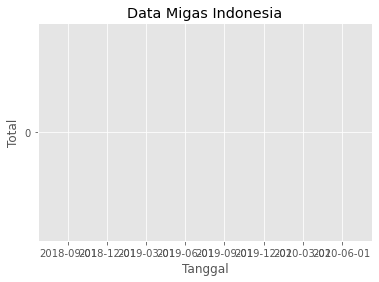

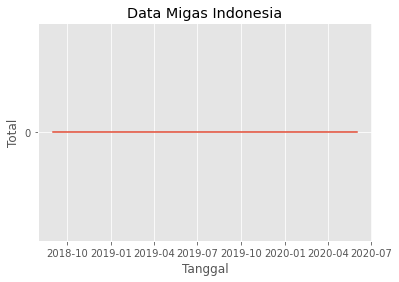

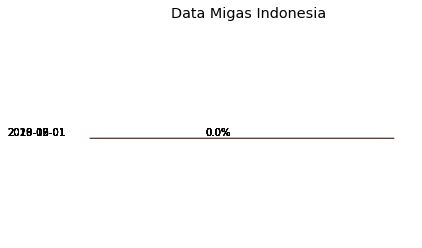

In [72]:
#BASE PATH UNTUK NANTINYA MENGCREATE FILE ATAU MEMANGGIL FILE
basePath = 'C:/Users/ASUS/Documents/bappenas/'
#FILE SIMILARITY WILAYAH
filePathwilayah = basePath+'data mentah/CEIC/allwilayah.xlsx';

#BACA FILE EXCEL DENGAN PANDAS
readexcelwilayah = pd.read_excel(filePathwilayah)
dfwilayah = list(readexcelwilayah.values)

readexcelwilayah.fillna(0)
allwilayah = []
#PEMILIHAN JENIS DATA, APA DATA ITU PROVINSI, KABUPATEN, KECAMATAN ATAU KELURAHAN
tipewilayah = 'prov'
if tipewilayah == 'prov':
    for x in range(0, len(dfwilayah)):
        allwilayah.append(dfwilayah[x][1])
elif tipewilayah=='kabkot':
    for x in range(0, len(dfwilayah)):
        allwilayah.append(dfwilayah[x][3])
elif tipewilayah == 'kec':
    for x in range(0, len(dfwilayah)):
        allwilayah.append(dfwilayah[x][5])
elif tipewilayah == 'kel':
    for x in range(0, len(dfwilayah)):
        allwilayah.append(dfwilayah[x][7])

semuawilayah = list(set(allwilayah))

#SETTING VARIABLE UNTUK DATABASE DAN DATA YANG INGIN DIKIRIMKAN KE FUNGSI DISINI
name = "01. Statistik Fintech (KBA001-KBA009)"
host = "localhost"
username = "postgres"
password = "1234567890"
port = "5432"
database = "ceic"
judul = "Produk Domestik Bruto (AA001-AA007)"
subjudul = "Badan Perencanaan Pembangunan Nasional"
filePath = basePath+'data mentah/CEIC/17. Sektor Perbankan/'+name+'.xlsx';
limitdata = int(8)
readexcel = pd.read_excel(filePath)
tabledata = []
wilayah = []
databody = []

#DATA EXCEL DIBACA DISINI DENGAN MENGGUNAKAN PANDAS
df = list(readexcel.values)
head = list(readexcel)
body = list(df[0])
readexcel.fillna(0)
#PILIH ROW DATA YANG INGIN DITAMPILKAN
rangeawal = 106
rangeakhir = 107
rowrange = range(rangeawal, rangeakhir)

#INI UNTUK MEMFILTER APAKAH DATA YANG DIPILIH MEMILIKI SIMILARITAS ATAU TIDAK
#ISIKAN 'WILAYAH' UNTUK SIMILARITAS
#ISIKAN BUKAN WILAYAH JIKA BUKAN WILAYAH
jenisdata = "Indonesia"

#ROW DATA DI LOOPING UNTUK MENDAPATKAN SIMILARITAS WILAYAH

#JIKA VARIABLE JENISDATA WILAYAH AKAN MASUK KESINI
if jenisdata == 'Wilayah':
    for x in rowrange:
        rethasil = 0
        big_w = 0
        for w in range(0, len(semuawilayah)):
            namawilayah = semuawilayah[w].lower().strip()      
            nama_wilayah_len = len(namawilayah)      
            hasil = n0.get_levenshtein_similarity(df[x][0].lower().strip()[nama_wilayah_len*-1:], namawilayah)      
            if hasil > rethasil:
                rethasil = hasil
                big_w = w
        wilayah.append(semuawilayah[big_w].capitalize())
        tabledata.append('produkdomestikbruto_'+semuawilayah[big_w].lower().replace(" ", "") + "" + str(x))
        testbody = []
        for listbody in df[x][11:]:
            if ~np.isnan(listbody) == False:
                testbody.append(str('0'))
            else:
                testbody.append(str(listbody))
        databody.append(testbody)
#JIKA BUKAN WILAYAH MASUK KESINI
else:
    for x in rowrange:
        wilayah.append(jenisdata.capitalize())
        tabledata.append('produkdomestikbruto_'+jenisdata.lower().replace(" ", "") + "" + str(x))
        testbody = []
        for listbody in df[x][11:]:
            if ~np.isnan(listbody) == False:
                testbody.append(str('0'))
            else:
                testbody.append(str(listbody))
        databody.append(testbody)

#HEADER UNTUK PDF DAN EXCEL
A2 = "Data Migas"
B2 = df[rangeawal][1]
C2 = df[rangeawal][2]
D2 = df[rangeawal][3]
E2 = df[rangeawal][4]
F2 = df[rangeawal][5]
G2 = df[rangeawal][6]
H2 = df[rangeawal][7]
I2 = df[rangeawal][8]
J2 = df[rangeawal][9]
K2 = df[rangeawal][10]

#DATA ISI TABLE F2
dataheader = []
for listhead in head[11:]:
    dataheader.append(str(listhead))

#FUNGSI UNTUK UPLOAD DATA KE SQL, JIKA BERHASIL AKAN MAMANGGIL FUNGSI UPLOAD CHART
sql = uploadToPSQL(host, username, password, database, port, tabledata, judul, filePath, name, subjudul, dataheader, databody)
if sql == True:
    makeChart(host, username, password, database, port, tabledata, judul, filePath, name, subjudul, A2, B2, C2, D2, E2, F2, G2, H2,I2, J2, K2, limitdata, wilayah, tabledata, basePath)
else:
    print(sql)